In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import arviz as az
import warnings
warnings.filterwarnings("ignore") 
import scipy.stats as st
from patsy import dmatrix, dmatrices

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 15.2 Data generation

In [5]:
np.random.seed(1234)
n_groups = 3
n_sample = 100
n = n_groups * n_sample
pop = np.repeat(['Pyrenees', 'MCentral', 'Jura'], n_sample)
length = st.uniform.rvs(4.5, 2.5, size = n)
length = length - length.mean()

data_ds = pd.DataFrame({'pop': pd.Series(pop, dtype = 'category'), 'length': length})
Xmat = dmatrix("~ C(pop, Treatment('Pyrenees')) * length", data_ds, return_type = 'dataframe')

#cols = Xmat.columns.to_list()
Xmat = Xmat[['Intercept', 
        "C(pop, Treatment('Pyrenees'))[T.MCentral]", 
        "C(pop, Treatment('Pyrenees'))[T.Jura]", 
        'length',
        "C(pop, Treatment('Pyrenees'))[T.MCentral]:length", 
        "C(pop, Treatment('Pyrenees'))[T.Jura]:length"]].to_numpy()

beta_vec = [-2, 1, 2, 5, -2, -7]
lin_pred = Xmat @ beta_vec
λ = np.exp(lin_pred)
pload = np.random.poisson(λ)
data = pd.DataFrame({'pload': pload, 'pop': pd.Series(pop, dtype = 'category'), 'length': length})

**FIGURE 15.2**

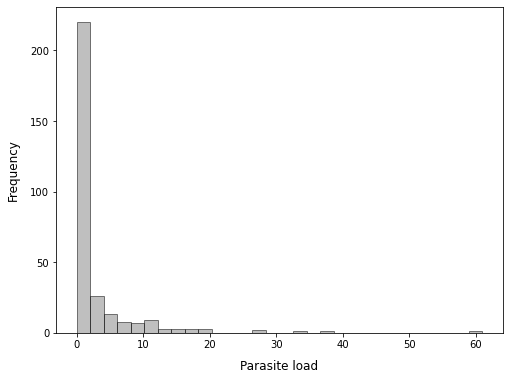

In [6]:
plt.figure(figsize = (8, 6))
plt.hist(pload, bins = 30, color= 'gray', edgecolor='black', alpha = 0.5)
plt.xlabel('Parasite load', fontsize = 12, labelpad = 10)
plt.ylabel('Frequency', fontsize = 12, labelpad = 10);

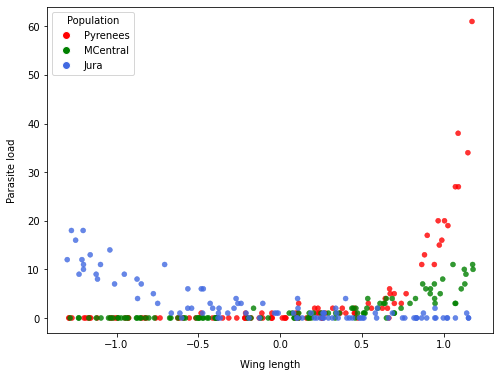

In [7]:
plt.figure(figsize = (8, 6))
colors = {"Pyrenees": 'red', "MCentral": 'green', "Jura": 'royalblue'}
plt.scatter(data['length'], data['pload'], marker='o', s=25, linewidths=0.5, c=data['pop'].map(colors), alpha = 0.8)
plt.xlabel('Wing length', fontsize = 10, labelpad = 10)
plt.ylabel('Parasite load', fontsize = 10, labelpad = 10)
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='Population', handles=handles, loc='upper left');

### 15.4 Analysis using PyMC3

In [8]:
idx = pd.factorize(pop)[0] 
groups = len(np.unique(idx))

In [9]:
with pm.Model() as model_15_4_1:
    alpha = pm.Normal('alpha', 0, tau = 0.01, shape = groups)
    beta = pm.Normal('beta', 0, tau = 0.01, shape = groups)
    λ = pm.Deterministic('λ', pm.math.exp(alpha[idx] + beta[idx] * length))
    C_pred = pm.Poisson('C_pred', λ, observed = pload)
    
    # Recover effects relative to baseline level (no. 1)
    a_effe2 = pm.Deterministic('a_effe2', alpha[1] - alpha[0])     # Intercept Massif Central vs. Pyr.
    a_effe3 = pm.Deterministic('a_effe3', alpha[2] - alpha[0])     # Intercept Jura vs. Pyr.
    b_effe2 = pm.Deterministic('b_effe2', beta[1] - beta[0])       # Slope Massif Central vs. Pyr.
    b_effe3 = pm.Deterministic('b_effe3', beta[2] - beta[0])       # Slope Jura vs. Pyr.

    # Custom test
    test1 = pm.Deterministic('test1', beta[2] - beta[1])          # Slope Jura vs. Massif Central
    trace_15_4_1 = pm.sample(target_accept = 0.97, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.


In [10]:
az.summary(trace_15_4_1, var_names = ['alpha', 'beta', 'a_effe2', 'a_effe3', 'b_effe2', 'b_effe3'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.601,0.223,-2.046,-1.211,0.009,0.006,675.0,801.0,1.0
alpha[1],-1.114,0.225,-1.516,-0.677,0.007,0.005,933.0,975.0,1.0
alpha[2],0.117,0.113,-0.079,0.330,0.003,0.003,1043.0,878.0,1.0
beta[0],4.600,0.228,4.190,5.025,0.009,0.006,669.0,814.0,1.0
beta[1],2.905,0.243,2.488,3.376,0.008,0.006,937.0,980.0,1.0
beta[2],-1.987,0.117,-2.205,-1.779,0.004,0.003,962.0,914.0,1.0
a_effe2,0.488,0.315,-0.113,1.073,0.011,0.008,851.0,711.0,1.0
a_effe3,1.718,0.249,1.294,2.194,0.010,0.007,682.0,942.0,1.0
b_effe2,-1.695,0.335,-2.383,-1.110,0.011,0.008,860.0,718.0,1.0
b_effe3,-6.587,0.258,-7.090,-6.125,0.009,0.007,761.0,717.0,1.0


#### 15.4.2 Forming predictions

In [11]:
alphas = trace_15_4_1.posterior.stack(samples = {'chain', 'draw'})['alpha'].values.T
betas = trace_15_4_1.posterior.stack(samples = {'chain', 'draw'})['beta'].values.T

In [12]:
original_wlength = np.sort(st.uniform.rvs(4.5, 2.5, size = 100))
wlength = original_wlength - 5.75
idx = range(0, alphas.shape[0], 150)

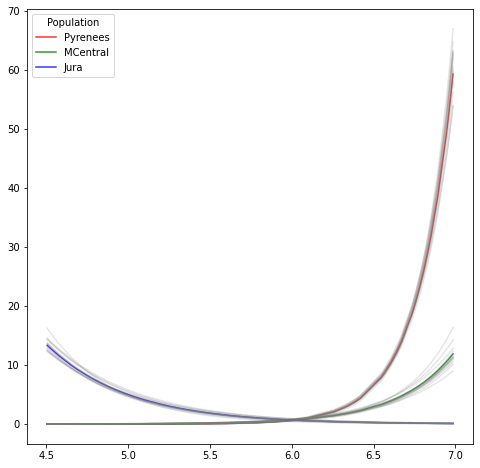

In [13]:
plt.figure(figsize = (8,8))
# Pyrenees
plt.plot(original_wlength, 
         np.exp(alphas[:, 0].mean() + betas[:, 0].mean() * wlength[:,np.newaxis]), 
         c='red', 
         alpha=0.8,
         label = 'Pyrenees')
plt.plot(original_wlength, np.exp(alphas[idx, 0] + betas[idx, 0] * wlength[:,np.newaxis]), c='gray', alpha=0.2)

# MCentral
plt.plot(original_wlength, 
         np.exp(alphas[:, 1].mean() + betas[:, 1].mean() * wlength[:,np.newaxis]), 
         c='green', 
         alpha=0.8, 
         label = 'MCentral')
plt.plot(original_wlength, np.exp(alphas[idx, 1] + betas[idx, 1] * wlength[:,np.newaxis]), c='gray', alpha=0.2)

# Jura
plt.plot(original_wlength, 
         np.exp(alphas[:, 2].mean() + betas[:, 2].mean() * wlength[:,np.newaxis]), 
         c='blue', 
         alpha=0.8,
        label = 'Jura')
plt.plot(original_wlength, np.exp(alphas[idx, 2] + betas[idx, 2] * wlength[:,np.newaxis]), c='gray', alpha=0.2)
plt.legend(title = 'Population', loc = 'upper left');